In [3]:
%matplotlib notebook

from collections import Counter
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from imgaug import augmenters as iaa
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from pycocotools.coco import COCO
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

from abyss_deep_learning.keras.classification import FromAnnDataset, ClassificationDataset, caption_map_gen, onehot_gen
from abyss_deep_learning.keras.utils import batching_gen, lambda_gen
import abyss_deep_learning.abyss_dataset as dataset_model

Using TensorFlow backend.


In [2]:
import sys
sys.version_info


sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)

# Setup Data

In [4]:
############### CONFIGURE THIS ########################
# num_classes assumed from caption_map entries
image_dims = (299, 299, 3) # Preset for InceptionV3
batch_size = 1 # Just supporting 1 right now
log_dir = "/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/"

# maps caption strings to class numbers (ensure minimal set of class numbers)
# eg use {0, 1, 2} not {4, 7, 8}

coco_train = FromAnnDataset("/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/annotations/training-negs.json")
coco_val = FromAnnDataset("/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/annotations/validation-negs.json")
coco_test = FromAnnDataset("/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/annotations/validation-negs.json")

caption_map_train = {cat['name']: cat['id'] for cat in coco_train.dataset['categories']}
print(caption_map_train)
caption_map_val = {cat['name']: cat['id'] for cat in coco_val.dataset['categories']}
print(caption_map_val)

caption_map = caption_map_train

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
{'JD_ML': 5, 'IP': 4, 'DD': 1, 'ED_All': 3, 'JD_S': 2, 'Background': 6}
{'JD_ML': 5, 'IP': 4, 'DD': 1, 'ED_All': 3, 'JD_S': 2, 'Background': 6}


In [20]:
ds = coco_val
imgIds = [ann['image_id'] for ann in ds.loadAnns(ids=ds.getAnnIds())]
for image_id in set(imgIds):
    caps = [annotation['category_id']
            for annotation in ds.loadAnns(ds.getAnnIds([image_id]))
            ]
    print(image_id,set(caps))

1 {1, 2, 3, 4}
2 {3, 4}
3 {3, 4}
4 {3, 4}
5 {4}
6 {1, 2, 3, 4}
7 {2, 4}
8 {2}
9 {4}
10 {4}
11 {4}
12 {4}
13 {2, 4}
14 {4}
15 {3, 4}
16 {3, 4}
17 {2}
18 {1, 4}
19 {2}
20 {2, 4}
21 {2, 4}
22 {2, 3, 4}
23 {2, 3, 4}
24 {4}
25 {3}
26 {2}
27 {3, 4}
28 {4}
29 {3}
30 {5}
31 {5}
32 {5}
33 {5}
34 {5}
35 {5}
36 {5}
37 {5}
38 {5}
39 {1, 5}
40 {1, 5}
41 {5}
42 {5}
43 {5}
44 {5}
45 {5}
46 {5}
47 {5}
48 {1, 5}
49 {1, 3, 5}
50 {5}
51 {1, 5}
52 {5}
53 {5}
54 {5}
55 {5}
56 {5}
57 {5}
58 {5}
59 {5}
60 {5}
61 {1, 3}
62 {3}
63 {3}
64 {3}
65 {3}
66 {3}
67 {3}
68 {3}
69 {3}
70 {1}
71 {1}
72 {1, 3}
73 {2}
74 {6}
75 {6}
76 {1}
77 {6}
78 {6}
79 {6}
80 {6}
81 {2}
82 {6}
83 {6}
84 {6}
85 {6}
86 {6}
87 {2}
88 {6}
89 {6}
90 {6}
91 {1, 2}
92 {6}
93 {1, 2}
94 {6}
95 {1, 2, 3}
96 {1, 2}
97 {6}
98 {6}
99 {6}
100 {6}
101 {1}
102 {6}
103 {2}
104 {6}
105 {6}
106 {6}
107 {6}
108 {6}
109 {6}
110 {2}
111 {6}
112 {6}
113 {6}
114 {2}
115 {2}


In [21]:
caption_map_r = {val: key for key, val in caption_map.items()}
num_classes = len(caption_map)+1
steps_per_epoch = coco_train.num_images()
steps_per_epoch_val = coco_val.num_images()
print("Number of classes:", num_classes)
print("Steps per epoch:", steps_per_epoch)
print("Steps per steps_per_epoch_val:", steps_per_epoch_val)

Number of classes: 7
Steps per epoch: 594
Steps per steps_per_epoch_val: 211


In [6]:
# for annotation in coco_train.loadAnns(coco_train.getAnnIds([1])):
#     print(annotation['category_id'])

In [7]:
# caps = [annotaion['category_id']
#          for annotation in self.loadAnns(self.getAnnIds([image_id]))]
# #          for caption in annotation['annotations']]


In [22]:
def preprocess(image, caption):
    image = resize(image, image_dims, preserve_range=True)
    return preprocess_input(image.astype(np.float32)), caption
def postprocess(image):
    return ((image + 1) * 127).astype(np.uint8)

def pipeline(gen, aug_config=None):
    return (
        augmentation_gen(
            onehot_gen(
                lambda_gen(
                    gen
#                     caption_map_gen(gen, caption_map)
                , func=preprocess)
            , num_classes=num_classes)
        , aug_config, enable=(aug_config is not None))
    )

def augmentation_gen(gen, aug_config, enable=True):
    '''
    Data augmentation for classification task.
    Target is untouched.
    '''
    if not enable:
        while True:
            yield from gen
    aug_list = []
    if 'flip_lr_percentage' in aug_config:
        aug_list += [iaa.Fliplr(aug_config['flip_lr_percentage'])]
    if 'flip_ud_percentage' in aug_config:
        aug_list += [iaa.Flipud(aug_config['flip_ud_percentage'])]
    if 'affine' in aug_config:
        aug_list += [iaa.Affine(**aug_config['affine'])]
#     if 'color' in aug_config: #  Color aug not working  yet
#         aug_list += [iaa.Sometimes(
#             aug_config['color']['probability'], iaa.Sequential([
#             iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
#             iaa.WithChannels(0, iaa.Add(aug_config['color']['hue'])),
#             iaa.WithChannels(1, iaa.Add(aug_config['color']['saturation'])),
#             iaa.WithChannels(2, iaa.Add(aug_config['color']['value'])),
#             iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")
#         ]))]
    seq = iaa.Sequential(aug_list)
    for image, target in gen:
        yield seq.augment_image(image), target
        
aug_config = {
    'flip_lr_percentage': 0.5,
    'flip_ud_percentage': 0.5,
    'affine': {
        "order": 1,
        'scale': {
            "x": (0.8, 1.2),
            "y": (0.8, 1.2)
        },
        "rotate": (-10, 10),
        "shear": (-5, 5),
        "mode": 'constant'
    },
#     'color': {
#         'probability': 1.00,
#         'hue': (0, 0),
#         'saturation': (0, 0),
#         'value': (0, 0)
#     }
}


(299, 299, 3) [0 0 0 0 1 0 0]
(299, 299, 3) [0 0 0 1 1 0 0]
(299, 299, 3) [0 0 0 0 0 0 1]


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


<IPython.core.display.Javascript object>


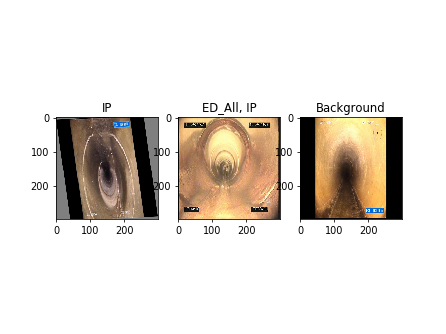

Left to right: ground truth samples from train, val test


In [42]:
  
train_gen = pipeline(
    coco_train.generator(shuffle_ids=True),
    aug_config=aug_config)
val_gen = pipeline(coco_val.generator(shuffle_ids=True))
test_gen = pipeline(coco_test.generator(shuffle_ids=True))
    
for i, (train, val, test) in enumerate(zip(train_gen, val_gen, test_gen)):
    print(train[0].shape, train[1])
    print(val[0].shape, val[1])
    print(test[0].shape, test[1])
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(postprocess(train[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(train[1])]))
    
    plt.subplot(1, 3, 2)
    plt.imshow(postprocess(val[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(val[1])]))
    
    plt.subplot(1, 3, 3)
    plt.imshow(postprocess(test[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(test[1])]))
    
    if i >= 0:
        break
print("Left to right: ground truth samples from train, val test")        

In [24]:
def gen_dump_data(gen, num_images):
    data = [[],[]]
    for i, (image, caption) in enumerate(gen):
        data[0].append(image)
        data[1].append(caption)
        if i >= num_images:
            break
    data = (
        np.concatenate([i[np.newaxis, ...] for i in data[0]], axis=0),
        np.concatenate([i[np.newaxis, ...] for i in data[1]], axis=0)
    )
    return data

def count_labels_multi(data):
    return Counter([int(j) for i in data[1] for j in np.argwhere(i)])



In [ ]:
val_data[1]

In [33]:
val_data = gen_dump_data(val_gen, coco_val.num_images())

# print(count_labels_multi(val_data))

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


[[[[-0.9607843  -1.         -0.8901961 ]
   [-0.9590268  -1.         -0.8884386 ]
   [-0.925018   -1.         -0.8625877 ]
   ...
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]]

  [[-0.9607843  -1.         -0.8901961 ]
   [-0.9590268  -1.         -0.8884386 ]
   [-0.925018   -1.         -0.8625877 ]
   ...
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]]

  [[-0.9607843  -1.         -0.8901961 ]
   [-0.9590268  -1.         -0.8884386 ]
   [-0.925018   -1.         -0.8625877 ]
   ...
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]
   [-0.99215686 -0.99215686 -0.99215686]]

  ...

  [[-1.         -0.9764706  -0.96862745]
   [-1.         -0.9764706  -0.96862745]
   [-1.         -0.9899889  -0.9821458 ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         

In [34]:
print(val_data[0].shape)

(212, 299, 299, 3)


In [60]:
val_data = gen_dump_data(val_gen, coco_val.num_images())
print(count_labels_multi(val_data))

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Counter({3: 73, 4: 69, 1: 64, 2: 62, 5: 50})


In [56]:
val_data = gen_dump_data(val_gen, coco_val.num_images())
print(count_labels_multi(val_data))

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Counter({3: 73, 4: 69, 1: 65, 2: 62, 5: 50})


In [27]:
print(train_data[0].shape)
print(train_data[1])

NameError: name 'train_data' is not defined

In [28]:
train_data = gen_dump_data(train_gen, coco_train.num_images())
val_data = gen_dump_data(val_gen, coco_val.num_images())
test_data = gen_dump_data(test_gen, coco_test.num_images())

for label, data in zip(
        ["train", "val", "test"],
        [train_data, val_data, test_data]):
    counter = count_labels_multi(data)
    print(label, counter)
    
train_counts = count_labels_multi(train_data)
class_weights =  1 / np.array([j for i, j in sorted(train_counts.items(), key=lambda x: x[0])], dtype=np.float32)
class_weights /= np.linalg.norm(class_weights)
class_weights = dict(zip(sorted(train_counts.keys()), class_weights.tolist()))
print("class_weights:")
print(class_weights)
del train_data

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


train Counter({3: 204, 1: 136, 2: 125, 5: 124, 4: 120, 6: 84})
val Counter({3: 74, 4: 70, 1: 64, 2: 62, 5: 49, 6: 30})
test Counter({3: 74, 4: 69, 1: 64, 2: 62, 5: 49, 6: 30})
class_weights:
{1: 0.3595154881477356, 2: 0.39115285873413086, 3: 0.23967699706554413, 4: 0.4074508845806122, 5: 0.39430728554725647, 6: 0.5820726752281189}


# Setup model

In [46]:
def create_new_head(base_model, num_classes, train_features=False, activation='softmax', opt_params={}):
    '''make sure base_model has include_top=False'''
    from keras.layers import Dense, MaxPooling2D, Dropout, Flatten
    from keras.models import Model
    # add a global spatial average pooling layer
    x = base_model.output
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation=activation, name='class_logits')(x)


    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = train_features
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(**opt_params, metrics=['accuracy'])
    return model

In [56]:
K.clear_session()
model = create_new_head(
    InceptionV3(
        include_top=False, weights='imagenet', input_shape=image_dims),
    num_classes, train_features=False, activation='sigmoid',
    opt_params={'optimizer': "Nadam", 'loss': "binary_crossentropy"})

# Train model

In [53]:
best_path = os.path.join(log_dir, "models/best.{epoch:03d}-{val_loss:.4f}.h5")

callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=9, cooldown=6, verbose=1),
        ModelCheckpoint(
            best_path, monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=True, mode='auto', period=1),
        TensorBoard(
            log_dir=log_dir,
            histogram_freq=0,
            batch_size=batch_size,
            write_graph=False,
            write_grads=False,
            write_images=False),
#         EarlyStopping(
#             monitor='val_loss', min_delta=0.0, patience=40, verbose=1, mode='auto')
]


In [ ]:
# Train with initial LR
learning_rate = 1e-4
K.set_value(model.optimizer.lr, learning_rate)
model.fit_generator(
    batching_gen(train_gen, batch_size=batch_size),
    validation_data=tuple(val_data),
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    class_weight=class_weights,
    callbacks=callbacks, 
    epochs=100,
    verbose=1)

Epoch 1/100


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


594/594 [==============================] - 111s 186ms/step - loss: 0.2322 - acc: 0.7049 - val_loss: 0.5287 - val_acc: 0.7642

Epoch 00001: val_loss improved from inf to 0.52874, saving model to /mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/models/best.001-0.5287.h5
Epoch 2/100
594/594 [==============================] - 114s 193ms/step - loss: 0.1992 - acc: 0.7674 - val_loss: 0.5264 - val_acc: 0.7642

Epoch 00002: val_loss improved from 0.52874 to 0.52640, saving model to /mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/models/best.002-0.5264.h5
Epoch 3/100
594/594 [==============================] - 110s 185ms/step - loss: 0.1885 - acc: 0.7888 - val_loss: 0.5190 - val_acc: 0.7642

Epoch 00003: val_loss improved from 0.52640 to 0.51900, saving model to /mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/models/best.003-0.5190.h5
Epoch 4/100
594/594 [==============================] - 111s 186ms/step - l

In [ ]:
# # Train with smaller LR
# learning_rate = 2e-6
# K.set_value(model.optimizer.lr, learning_rate)
# model.fit_generator(
#     batching_gen(train_gen, batch_size=batch_size),
#     validation_data=tuple(val_data),
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=steps_per_epoch_val,
#     callbacks=callbacks, 
#     epochs=10,
#     verbose=1)

In [ ]:
# Explicitly save model weights (note it is auto saved in the callback)
# model.save_weights("/tmp/where_you_want_it.h5")

# Multi-label Testing

In [20]:
# thresh = 0.1
# Y_true = test_data[1]
# Y_pred = model.predict(test_data[0])
# TP = (Y_pred > thresh) == (Y_true > thresh)
# print("Test accuracy: {:.2f}".format(np.count_nonzero(TP) / TP.size))

# for i, (image, true_caption, pred_caption) in enumerate(zip(test_data[0], test_data[1], Y_pred)):
#     if i % 4 == 0:
#         plt.tight_layout()
#         plt.figure(figsize=(5, 5))
# #     if i >= 4:
# #         break
#     plt.subplot(2, 2, 1 + (i % 4))
#     plt.imshow(postprocess(image))
#     plt.title("T: {:s}; P: {:s}".format(
#         ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(true_caption > thresh)]),
#         ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(pred_caption > thresh)])
#     ))
#     print(pred_caption)
# plt.tight_layout()

In [ ]:
thresh = 0.5
Y_true = test_data[1]
Y_pred = model.predict(test_data[0])
TP = (Y_pred > thresh) == (Y_true > thresh)
print("Test accuracy: {:.2f}".format(np.count_nonzero(TP) / TP.size))

for i, (image, true_caption, pred_caption) in enumerate(zip(test_data[0], test_data[1], Y_pred)):
    if i % 4 == 0:
        plt.tight_layout()
        plt.figure(figsize=(5, 5))
#     if i >= 4:
#         break
    plt.subplot(2, 2, 1 + (i % 4))
    plt.imshow(postprocess(image))
    plt.title("T: {:s}; P: {:s}".format(
        ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(true_caption > thresh)]),
        ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(pred_caption > thresh)])
    ))
    print(pred_caption)
plt.tight_layout()

In [ ]:
# def pipeline(gen, augment=False):
#     aug_config = {
#         'input_shape': image_size,
#         'output_shape': input_shape,
#         'spacing': 100,
#         'crop': False, # Only enable for object detection or segmentation datasets
#         'crops_per_image': 0, # Only enable for object detection or segmentation datasets
#         'flip_lr_percentage': 0.5,
#         'flip_ud_percentage': 0.5,
#         'affine': {
#             "order": 1,
#             'scale': {
#                 "x": (0.8, 1.2),
#                 "y": (0.8, 1.2)
#             },
#             "rotate": (-10, 10),
#             "shear": (-5, 5),
#             "mode": 'constant'
#         }
#     }
#     return (
#             lambda_gen(
#                 augmentation_gen(
#                     gen, aug_config=aug_config, enable=augment)
#             , func=preprocess)
#     )